### implementing U-Net

In [1]:
from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.layers import concatenate, Conv2DTranspose, UpSampling2D

def gen_U_Net(input_shape=(16, 16, 2)) :      # the input shape must be multiples of 16 (2**4)
    input_layer = Input(shape=input_shape)

    last_layer = input_layer
    concate_list = []
    filter_num = 64                     # set initial number of filters as 64
    for i in range(4) :
        conv1 = Conv2D(
            filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu",
            kernel_initializer="he_normal", padding="same", name="conv-{}_1".format(i + 1)
        )(last_layer)

        conv2 = Conv2D(
            filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu",
            kernel_initializer="he_normal", padding="same", name="conv-{}_2".format(i + 1)
        )(conv1)

        if i == 3 : 
            conv2 = Dropout(0.5)(conv2)
        batch = BatchNormalization()(conv2)
        max_pool = MaxPooling2D(pool_size=(2, 2))(batch)
        
        filter_num *= 2
        last_layer = max_pool
        concate_list.insert(0, conv2)
    
    conv5_1 = Conv2D(
        filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
        kernel_initializer="he_normal", padding="same", name="conv-5_1"
    )(last_layer)
    conv5_2 = Conv2D(
        filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
        kernel_initializer="he_normal", padding="same", name="conv-5_2"
    )(conv5_1)
    drop5 = Dropout(0.5)(conv5_2)

    last_layer = drop5

    for i, prev_layer in enumerate(concate_list) : 
        filter_num /= 2
        up_conv1 = UpSampling2D(size=(2, 2), name="upsample-{}".format(4 - i))(last_layer)
        up_conv2 = Conv2D(
            filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
            kernel_initializer="he_normal", padding="same", name="upconv-{}_1".format(4 - i)
        )(up_conv1)
        
        merge_layer = concatenate(inputs=[up_conv2, prev_layer], axis=3, name="merge-{}".format(4 - i))

        up_conv3 = Conv2D(
            filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
            kernel_initializer="he_normal", padding="same", name="upconv-{}_2".format(4 - i)
        )(merge_layer)
        up_conv4 = Conv2D(
            filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
            kernel_initializer="he_normal", padding="same", name="upconv-{}_3".format(4 - i)
        )(up_conv3)
        last_layer = up_conv4

    conv_restore = Conv2D(filters=2, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer="he_normal", padding="same", name="conv_restore")(last_layer)
    output_layer = Conv2D(filters=2, kernel_size=(1, 1), strides=(1, 1), activation="relu", kernel_initializer="he_normal", padding="same", name="conv-output")(conv_restore)
    
    return Model(inputs=[input_layer], outputs=[output_layer])


In [2]:
import librosa, os
from IPython.display import Audio

Data_path = os.path.pardir
Data_path += "/Data/kaggle_data/common-voice/"
test_data_path = Data_path + "cv-valid-train/cv-valid-train/sample-000006.mp3"

sample_rate = 22050

voice_source, sample_rate = librosa.load(test_data_path, sr=sample_rate, mono=True)

print("Voice")
print("Length : {}".format(len(voice_source)))
print("Sample rate : {}".format(sample_rate))
print("L / R : {:.2f} sec".format(len(voice_source) / sample_rate))
display(Audio(voice_source, rate=sample_rate))

music_data_path = "../Data/sample/Jonas Blue - Fast Car ft. Dakota (Official Video).mp3"

music_source, sample_rate = librosa.load(music_data_path, mono=True, duration=(len(voice_source) / sample_rate))

print("mMusic")
print("Length : {}".format(len(music_source)))
print("Sample rate : {}".format(sample_rate))
print("L / R : {:.2f} sec".format(len(music_source) / sample_rate))

display(Audio(music_source, rate=sample_rate))

print("Merge")
merge_source = voice_source + music_source

display(Audio(merge_source, rate=sample_rate))

Voice
Length : 172520
Sample rate : 22050
L / R : 7.82 sec


mMusic
Length : 172520
Sample rate : 22050
L / R : 7.82 sec


Merge


(800, 433) (800, 433) (800, 433)
(800, 432) (800, 432) (800, 432)


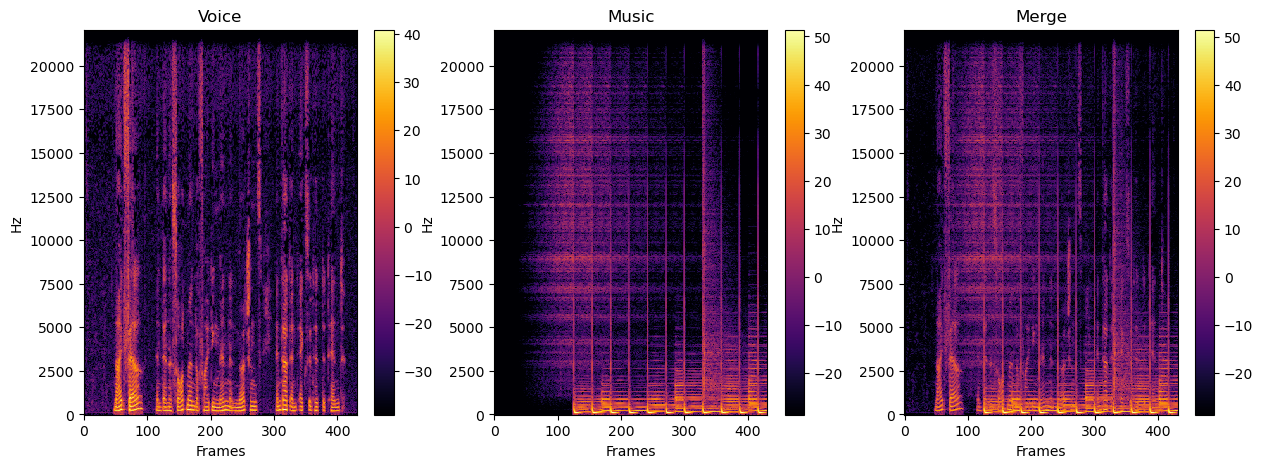

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# n_fft = 2 * (16 * input_shape - 1)        /       example - 1598
n_fft=1598
D_voice_raw = librosa.stft(voice_source, n_fft=n_fft)
D_music_raw = librosa.stft(music_source, n_fft=n_fft)
D_merge_raw = librosa.stft(merge_source, n_fft=n_fft)

print(D_voice_raw.shape, D_music_raw.shape, D_merge_raw.shape)

D_voice_raw = D_voice_raw[:,:432]
D_music_raw = D_music_raw[:,:432]
D_merge_raw = D_merge_raw[:,:432]
print(D_voice_raw.shape, D_music_raw.shape, D_merge_raw.shape)      # input shape must be multiple of 16

# try : 
#     del fig, axes
# finally : 
#     pass

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for ax, D, title in zip(axes, [np.abs(D_voice_raw), np.abs(D_music_raw), np.abs(D_merge_raw)], ["Voice", "Music", "Merge"]) : 
    S_db = librosa.amplitude_to_db(D)
    cb = librosa.display.specshow(S_db, x_axis="frames", y_axis="fft", sr=sample_rate * 2, ax=ax, cmap="inferno")
    ax.set_title(title)
    plt.colorbar(cb)


In [4]:
import numpy as np
def complex_to_polar(array) : 
    r = np.abs(array)
    angle = np.angle(array)
    
    result_array = np.zeros(shape=(*array.shape, 2), dtype=array[...,0].real.dtype)
    result_array[..., 0] = r
    result_array[..., 1] = angle
    
    return result_array

polar_voice = complex_to_polar(D_voice_raw)
polar_music = complex_to_polar(D_music_raw)
polar_merge = complex_to_polar(D_merge_raw)

print(polar_voice.shape, polar_music.shape, polar_merge.shape)

(800, 432, 2) (800, 432, 2) (800, 432, 2)


In [5]:
def polar_to_complex(array) : 
    from numpy import cos, sin
    
    r = array[..., 0]
    theta = array[..., 1]

    real_part = r * cos(theta)
    imag_part = r * sin(theta)
    
    complex_array = real_part + imag_part * 1j

    return complex_array

In [6]:
from keras.backend import clear_session
from keras.utils import plot_model

clear_session()
test_model = gen_U_Net(input_shape=polar_merge.shape)
test_model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800, 432, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv-1_1 (Conv2D)              (None, 800, 432, 64  1216        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv-1_2 (Conv2D)              (None, 800, 432, 64  36928       ['conv-1_1[0][0]']               
             

In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import r2_score

early_stop = EarlyStopping(monitor="loss", patience=20, verbose=False, restore_best_weights=True)
check_point = ModelCheckpoint(filepath="./U_Net_checkpoint/", monitor="loss", verbose=True, save_best_only=True, save_weights_only=True)
callbacks = [early_stop, check_point]

In [14]:
from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.layers import concatenate, Conv2DTranspose, UpSampling2D

input_layer = Input(shape=(800, 432, 2))

last_layer = input_layer
concate_list = []
filter_num = 64                     # set initial number of filters as 64
for i in range(4) :
    conv1 = Conv2D(
        filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu",
        kernel_initializer="he_normal", padding="same", name="conv-{}_1".format(i + 1)
    )(last_layer)

    conv2 = Conv2D(
        filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu",
        kernel_initializer="he_normal", padding="same", name="conv-{}_2".format(i + 1)
    )(conv1)

    if i == 3 : 
        conv2 = Dropout(0.5)(conv2)
    batch = BatchNormalization()(conv2)
    max_pool = MaxPooling2D(pool_size=(2, 2))(batch)
    
    filter_num *= 2
    last_layer = max_pool
    concate_list.insert(0, conv2)

conv5_1 = Conv2D(
    filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
    kernel_initializer="he_normal", padding="same", name="conv-5_1"
)(last_layer)
conv5_2 = Conv2D(
    filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
    kernel_initializer="he_normal", padding="same", name="conv-5_2"
)(conv5_1)
drop5 = Dropout(0.5)(conv5_2)

last_layer = drop5

for i, prev_layer in enumerate(concate_list) : 
    filter_num /= 2
    conv_trans = Conv2DTranspose(
        filters=filter_num, kernel_size=(3, 3), strides=(2, 2), activation="relu",
        kernel_initializer="he_normal", padding="same", name="ConvTrans-{}".format(4 - i)
    )(last_layer)
    
    merge_layer = concatenate(inputs=[conv_trans, prev_layer], axis=3, name="merge-{}".format(4 - i))

    up_conv3 = Conv2D(
        filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
        kernel_initializer="he_normal", padding="same", name="upconv-{}_2".format(4 - i)
    )(merge_layer)
    up_conv4 = Conv2D(
        filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
        kernel_initializer="he_normal", padding="same", name="upconv-{}_3".format(4 - i)
    )(up_conv3)
    last_layer = up_conv4

conv_restore = Conv2D(filters=2, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer="he_normal", padding="same", name="conv_restore")(last_layer)
output_layer = Conv2D(filters=2, kernel_size=(1, 1), strides=(1, 1), activation="relu", kernel_initializer="he_normal", padding="same", name="conv-output")(conv_restore)

test_model = Model(inputs=[input_layer], outputs=[output_layer])
test_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 800, 432, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv-1_1 (Conv2D)              (None, 800, 432, 64  1216        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv-1_2 (Conv2D)              (None, 800, 432, 64  36928       ['conv-1_1[0][0]']               
                                )                                                           

In [15]:
test_model.compile(optimizer="adam", loss="mse", metrics=["mse"])
history = test_model.fit(
    polar_merge.reshape((1, 800, 432, 2)), polar_voice.reshape((1, 800, 432, 2)),
    batch_size=1, epochs=500, verbose=2, callbacks=callbacks
)
test_model.save(filepath="./U_Net_checkpoint/checkpoint.h5")

Epoch 1/500

Epoch 1: loss improved from inf to 3.63745, saving model to ./U_Net_checkpoint/
1/1 - 3s - loss: 3.6374 - mse: 3.6374 - 3s/epoch - 3s/step
Epoch 2/500

Epoch 2: loss did not improve from 3.63745
1/1 - 1s - loss: 6.8584 - mse: 6.8584 - 756ms/epoch - 756ms/step
Epoch 3/500

Epoch 3: loss improved from 3.63745 to 3.60984, saving model to ./U_Net_checkpoint/
1/1 - 2s - loss: 3.6098 - mse: 3.6098 - 2s/epoch - 2s/step
Epoch 4/500

Epoch 4: loss did not improve from 3.60984
1/1 - 1s - loss: 3.6563 - mse: 3.6563 - 758ms/epoch - 758ms/step
Epoch 5/500

Epoch 5: loss did not improve from 3.60984
1/1 - 1s - loss: 3.6554 - mse: 3.6554 - 741ms/epoch - 741ms/step
Epoch 6/500

Epoch 6: loss did not improve from 3.60984
1/1 - 1s - loss: 3.6554 - mse: 3.6554 - 744ms/epoch - 744ms/step
Epoch 7/500

Epoch 7: loss did not improve from 3.60984
1/1 - 1s - loss: 3.6554 - mse: 3.6554 - 748ms/epoch - 748ms/step
Epoch 8/500

Epoch 8: loss did not improve from 3.60984
1/1 - 1s - loss: 3.6554 - mse: 

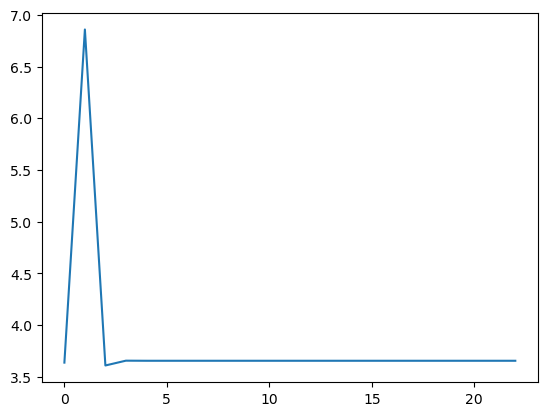

In [16]:
import matplotlib.pyplot as plt

epoch = history.epoch
loss = history.history["loss"]
mse = history.history["mse"]

plt.plot(epoch, loss)
plt.show()

In [17]:
pred_polar = test_model.predict(polar_merge.reshape((1, 800, 432, 2)), batch_size=1)
print(pred_polar.shape)
pred = polar_to_complex(pred_polar)
pred = pred.reshape((800, 432))
print(pred.shape)

1/1 [==============================] - 0s 351ms/step
(1, 800, 432, 2)
(800, 432)


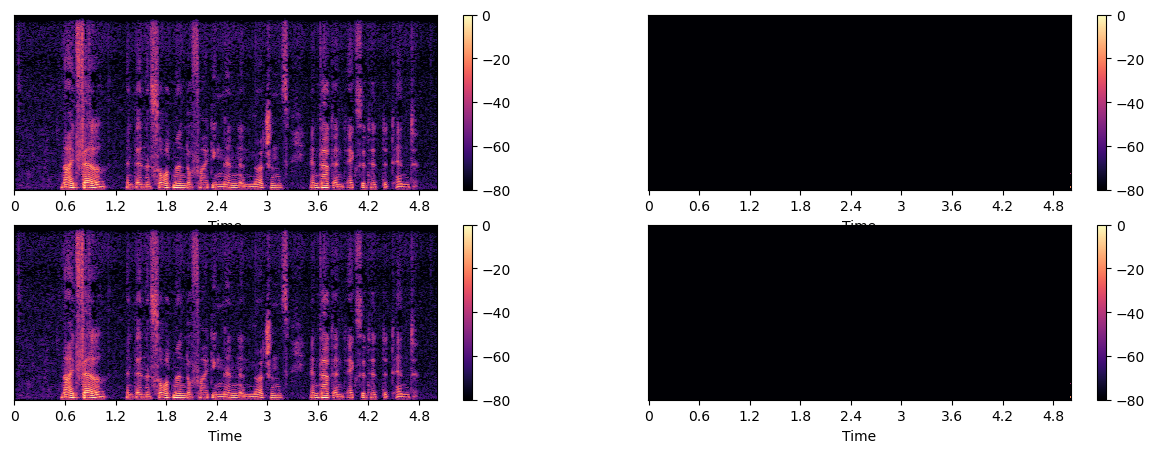

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))

for ax, data in zip(axes[0], [np.abs(D_voice_raw), np.abs(pred)]) : 
    D_db = librosa.amplitude_to_db(data, ref=np.max)
    cb = librosa.display.specshow(D_db, x_axis="time", sr=sample_rate * 2, ax=ax)
    plt.colorbar(cb)

for ax, data in zip(axes[1], [np.abs(D_voice_raw), np.abs(pred)]) : 
    D_db = librosa.amplitude_to_db(data, ref=np.max)
    cb = librosa.display.specshow(D_db, x_axis="time", sr=sample_rate * 2, ax=ax)
    plt.colorbar(cb)

plt.show()

In [19]:
voice_inverse = librosa.istft(D_voice_raw)
pred_inverse = librosa.istft(pred, n_fft=n_fft)

print(voice_inverse.shape, pred_inverse.shape)
display(Audio(voice_inverse, rate=sample_rate))
display(Audio(pred_inverse, rate=sample_rate))

(171969,) (171969,)
